Setup

In [1]:
import torch
from datasets import load_dataset
from transformers import pipeline, AutoConfig, AutoModel
import ipywidgets as widgets
from IPython.display import display
import time
import math
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

%config InteractiveShell.ast_node_interactivity = 'all'
%config DisplayFormatter.float_precision = 10

Functions for Results Analysis

In [91]:
# Turn inference results into Pandas results table
def results_table(inference_results, image_data):
    """
    Input: 
        List of results inferred from huggingface model(s)

    Output: 
        Results simplified to Pandas Table per model
    """
    res_tables = {}    
    
    # Change Format of Results to Pandas DataFrame
    for i in range(len(inference_results)):
        # Results for model i in model results list
        m_result = list(inference_results.items())[i][1]
        image_qty = len(m_result)
        
        # Reformat to Pandas DataFrame for model result i 
        res = pd.DataFrame()
        for j in range(len(m_result)):
            join = pd.DataFrame({'label': [m_result[j][1]['label']], 'score': [round(m_result[j][1]['score'], 5)]})
            res = pd.concat([res, join])
    
        # Simplify to only give 'real' probabilities 
        res = res.reset_index(drop=True)
        res['y_hat'] = np.where(res.label == 'Fake', 1 - res.score, res.score)
        res['label'] = np.where(res.label == 'Fake', 'Real', res.label)

        # Add true labels and error terms
        res['y_true'] = image_data['train'][0:image_qty]['label']
        res['error'] = abs(res['y_true'] - res['y_hat']).round(6)
        
        # Save results of model i to results table
        res_df = f'model_{i+1}_res'
        res_tables[res_df] = res

    return res_tables

def classification_plots(res):
    """
    Input: 
        List of results as a pandas dataframe
        
    Output: 
        ROC curve and confusions matricies per model
    """
    # Get optimal threshold
    fpr, tpr, threshold = metrics.roc_curve(res['y_true'], res['y_hat'])

    transform_threshold = [0] * len(threshold)
    for i in range(len(threshold)):
        transform = ([1]-fpr[i])**2 + tpr[i]**2
        transform_threshold[i] = math.sqrt(transform);  

    transform_threshold = np.array(transform_threshold);  
    max_thresh = threshold[transform_threshold.argmax(axis=0)]

    # Apply optimal threshold
    res['y_pred'] = np.where(res['y_hat'] > max_thresh, 1, 0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Roc plot
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_plot = (sns.lineplot(x=fpr, y=tpr, errorbar=None, ax=ax1, 
                                estimator=None, label='AUC='+str(round(roc_auc, 5)))
                       .set(title='ROC curve', ylabel='True Positive Rate', xlabel='False Positive Rate'));  

    # Confusion Matricies
    cm = confusion_matrix(res['y_true'], res['y_pred']);  
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', ax=ax2).set(title='Classification Quantities'); 

    cm2 = np.round(confusion_matrix(res['y_true'], res['y_pred'])/(len(res['y_pred'])/100), 2)
    sns.heatmap(cm2, annot=True, cmap='Greens', fmt='g', ax=ax3).set(title='Classification Percent of Data'); 
    

def resize_img(images): 
    """
    Input: 
        Image Dataset
        
    Output: 
        Image Dataset with images resized to 256 by 256
    """
    images['image'] = [img.convert('RGB').resize((256, 256)) for img in images['image']]
    return images

def model_auc(res):
    """
    Input: 
        Results table from results_table function
        
    Output: 
        The AUC score for those model results
    """
    fpr, tpr, threshold = metrics.roc_curve(res['y_true'], res['y_hat'])
    model_auc = round(metrics.auc(fpr, tpr), 4)
    return model_auc


Dataset Load and Preview

In [3]:
image_dt_1 = load_dataset("Whab/deepfake").shuffle(seed=12); 
image_dt_2 = load_dataset("JamieWithofs/Deepfake-and-real-images-2").shuffle(seed=12); 
image_dt_3 = load_dataset("Hemg/deepfake-and-real-images").shuffle(seed=12);  
image_dt_4 = load_dataset("thenewsupercell/new-deepfake-and-real-images").shuffle(seed=12);  

In [4]:
print('Dataset Image Dimensions:',image_dt_1['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_1.num_rows, '\n', '       Features:', image_dt_1['train'].features)
print('Dataset Image Dimensions:',image_dt_2['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_2.num_rows, '\n', '       Features:', image_dt_2['train'].features)
print('Dataset Image Dimensions:',image_dt_3['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_3.num_rows, '\n', '       Features:', image_dt_3['train'].features)
print('Dataset Image Dimensions:',image_dt_4['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_4.num_rows, '\n', '       Features:', image_dt_4['train'].features)

Dataset Image Dimensions: (256, 256) 
        Number of Images: {'train': 179430} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}
Dataset Image Dimensions: (286, 256) 
        Number of Images: {'train': 3264, 'test': 1069, 'validation': 1072} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}
Dataset Image Dimensions: (256, 256) 
        Number of Images: {'train': 190335} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}
Dataset Image Dimensions: (256, 256) 
        Number of Images: {'train': 152268, 'validation': 19033, 'test': 19034} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}


In [5]:
# Convert images with resize_img function
start = time.time()
image_dt_2 = image_dt_2.map(resize_img, batched=True, batch_size=256)
end = time.time() - start
print('Image Resize Time:', round(end, 2))

Image Resize Time: 0.36


In [ ]:
preview_num = 3
sample_images_1 = image_dt_1['train'][0:preview_num]
sample_images_2 = image_dt_2['train'][0:preview_num]
sample_images_3 = image_dt_3['train'][0:preview_num]
sample_images_4 = image_dt_4['train'][0:preview_num]

## Preview Images
for i in range(preview_num):
    display(sample_images_1['image'][i]) 
for i in range(preview_num):
    display(sample_images_2['image'][i])
for i in range(preview_num):
    display(sample_images_3['image'][i])
for i in range(preview_num):
    display(sample_images_4['image'][i])

Models to Compare

In [7]:
%%capture
m1 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True, device='cuda'); 
m2 = pipeline("image-classification", model="Hemg/Deepfake-Detection", use_fast=True, device='cuda')
m3 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", use_fast=True, device='cuda')
m4 = pipeline("image-classification", model="romitbarua/autotrain-deepfakeface_only_faces_insightface-94902146221", use_fast=True, device='cuda')
m5 = pipeline("image-classification", model="Wvolf/ViT_Deepfake_Detection", use_fast=True, device='cuda')
# m1 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True); 
# m2 = pipeline("image-classification", model="Hemg/Deepfake-Detection", use_fast=True)
# m3 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", use_fast=True)
# m4 = pipeline("image-classification", model="romitbarua/autotrain-deepfakeface_only_faces_insightface-94902146221", use_fast=True)
# m5 = pipeline("image-classification", model="Wvolf/ViT_Deepfake_Detection", use_fast=True)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


Inference by model

In [72]:
# Quantity of images to classify per dataset
image_qty = 10 # 3264

# Models to compare
model_list = [m1, m2, m3, m4, m5] 
model_names = ['m1', 'm2', 'm3', 'm4', 'm5']

# Datasets to test
dt_list = [image_dt_1, image_dt_2, image_dt_3, image_dt_4]
dt_names = ['image_dt_1', 'image_dt_2', 'image_dt_3', 'image_dt_4']

# Initializaing results dictionaries
results_1, results_2, results_3, results_4 = {}, {}, {}, {}
res_dt_pairs = [[image_dt_1, results_1], [image_dt_2, results_2], [image_dt_3, results_3], [image_dt_4, results_4]]


# run_times = []

# create model runtime pairs here
model_runtimes = pd.DataFrame({'data': [], 'model': [], 'run_time': []})
for k, pair in enumerate(res_dt_pairs):
    for i, model in enumerate(model_list, start=1):
        results_df = f'raw_model_{i}'
        
        start = time.time()
        pair[1][results_df] = model(pair[0]['train'][0:image_qty]['image']);  
        end = round(time.time() - start, 2)
        runtime = pd.DataFrame({'data': dt_names[k], 'model': [model_names[i-1]], 'run_time': [end]})
        model_runtimes = pd.concat([model_runtimes, runtime])

In [73]:
model_runtimes


,data,model,run_time
0,image_dt_1,m1,3.64
0,image_dt_1,m2,3.59
0,image_dt_2,m1,4.54
0,image_dt_2,m2,3.52
0,image_dt_3,m1,6.70
0,image_dt_3,m2,5.93
0,image_dt_4,m1,5.87
0,image_dt_4,m2,5.38


Create Results Tables

In [74]:
res_table_1 = results_table(results_1, image_dt_1)
res_table_2 = results_table(results_2, image_dt_2)
res_table_3 = results_table(results_3, image_dt_3)
res_table_4 = results_table(results_4, image_dt_4)


Model Results on 1st Dataset

Order of results: ['m1', 'm2']


,model,auc
0,m1,1.0
0,m2,1.0


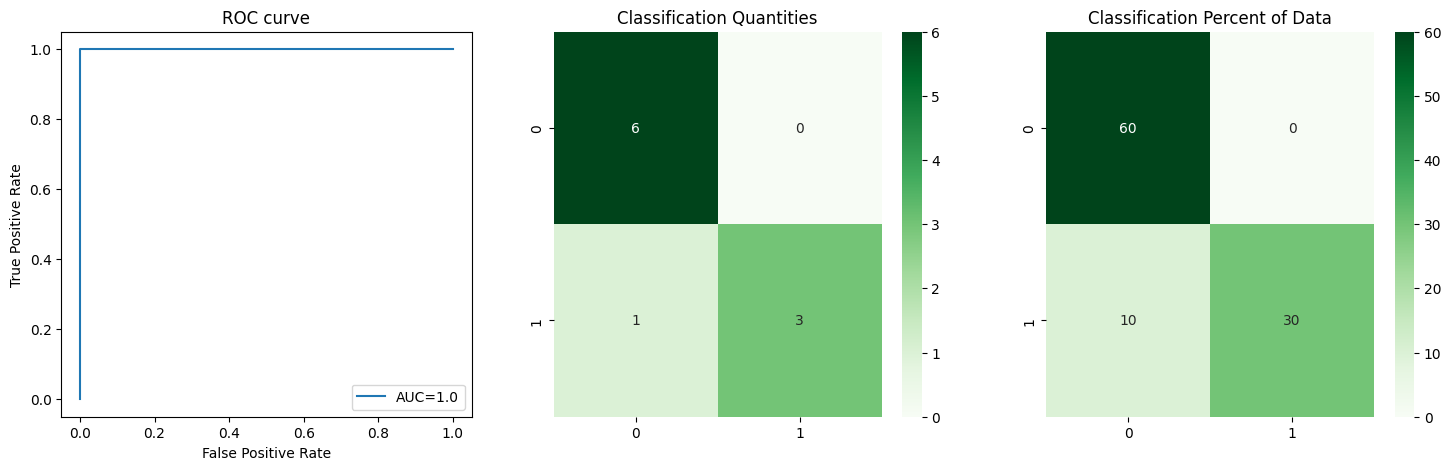

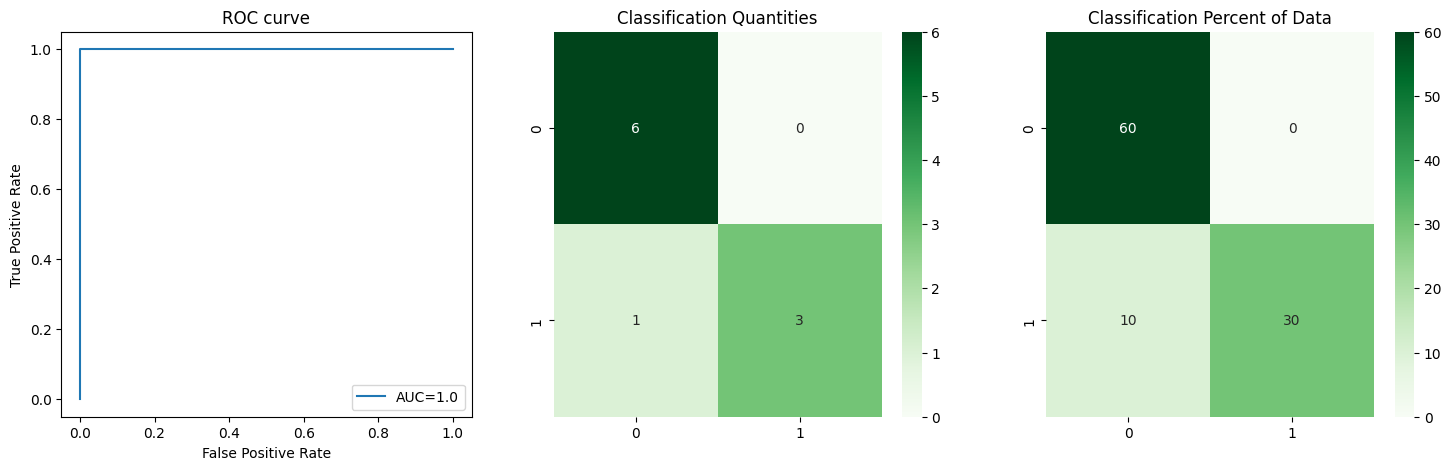

In [77]:
# Initialize model_auc DF for all results
model_aucs = pd.DataFrame({'model': [], 'auc': []})

# Calculate AUC
for i, tbl in enumerate(res_table_1.keys()):
    auc_i = pd.DataFrame({'model': [model_names[i]], 'auc': [model_auc(res_table_1[tbl])]})
    model_aucs = pd.concat([model_aucs, auc_i])

# Results for first dataset
print('Order of results:', model_names)
for i, tbl in enumerate(res_table_1.keys()):
    classification_plots(res_table_1[tbl])


Model Results on 2nd Dataset

Order of results: ['m1', 'm2']
Order of results: ['m1', 'm2']


,model,auc
0,m1,1.000000
0,m2,1.000000
0,m1,0.285714
0,m2,0.761905


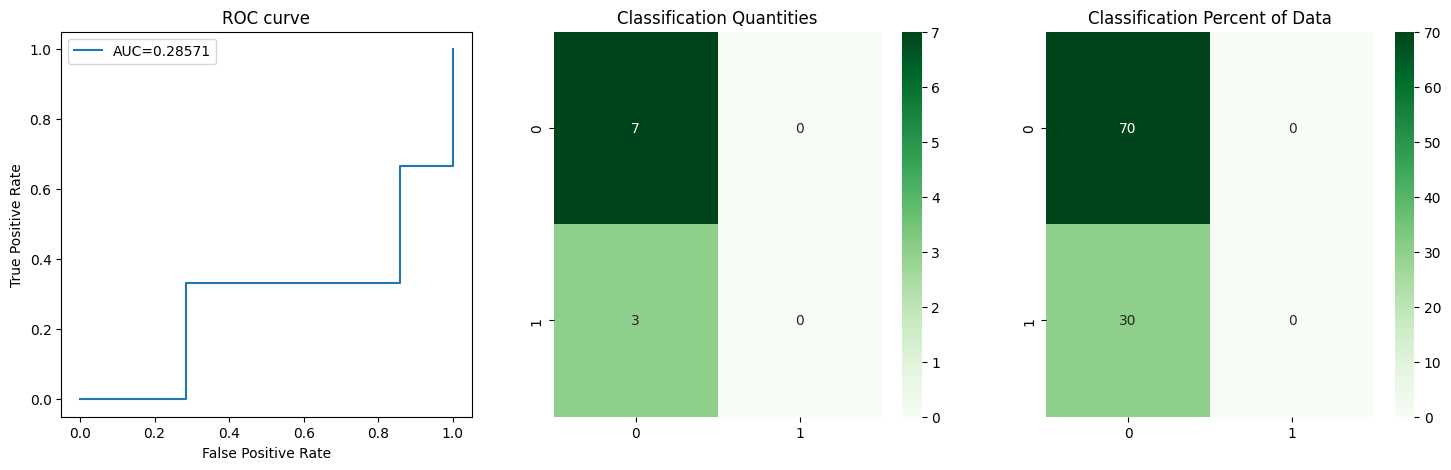

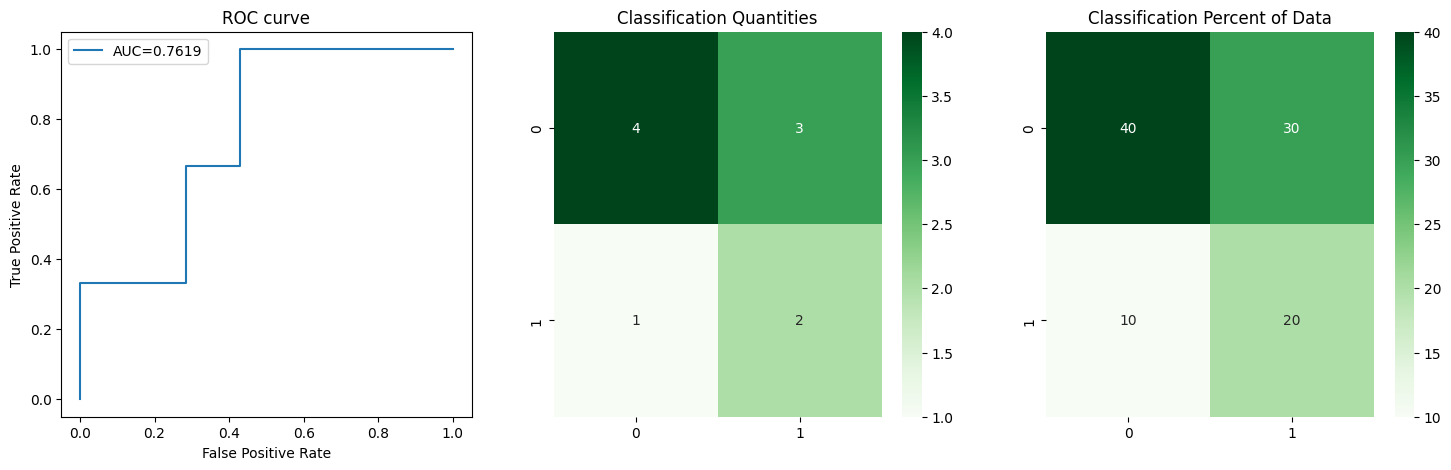

In [78]:
# Results for second dataset
print('Order of results:', model_names)
# Calculate AUC
for i, tbl in enumerate(res_table_2.keys()):
    auc_i = pd.DataFrame({'model': [model_names[i]], 'auc': [model_auc(res_table_2[tbl])]})
    model_aucs = pd.concat([model_aucs, auc_i])

# Results for first dataset
for i, tbl in enumerate(res_table_2.keys()):
    classification_plots(res_table_2[tbl])


Model Results on 3rd Dataset

Order of results: ['m1', 'm2']


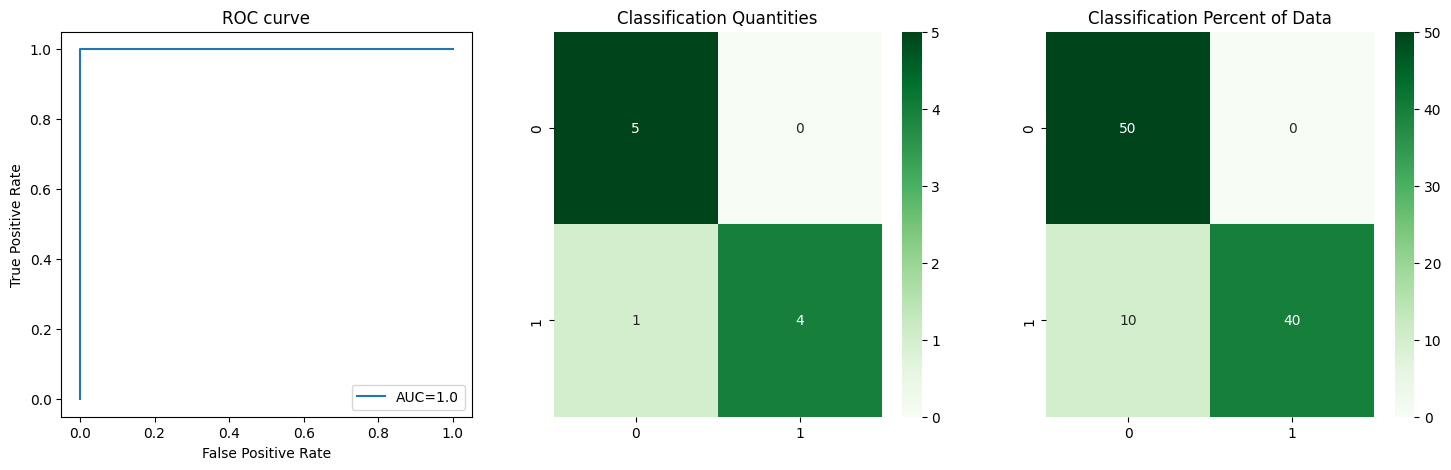

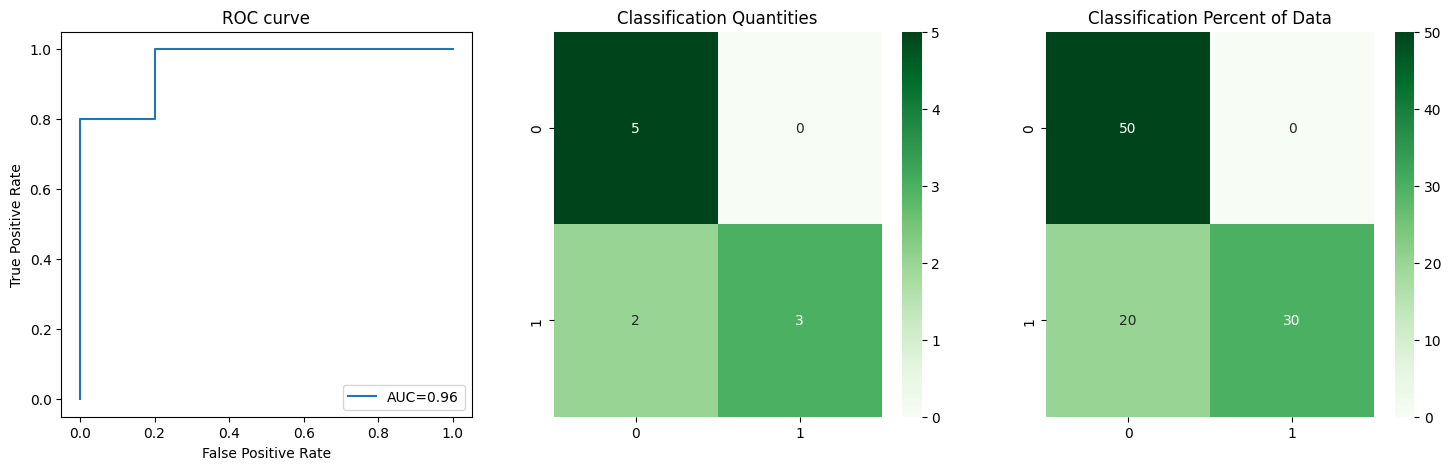

In [80]:
# Results for third dataset
print('Order of results:', model_names)
# Calculate AUC
for i, tbl in enumerate(res_table_3.keys()):
    auc_i = pd.DataFrame({'model': [model_names[i]], 'auc': [model_auc(res_table_3[tbl])]})
    model_aucs = pd.concat([model_aucs, auc_i])

# Results for first dataset
for i, tbl in enumerate(res_table_3.keys()):
    classification_plots(res_table_3[tbl])

Model Results on 4th Dataset

Order of results: ['m1', 'm2']


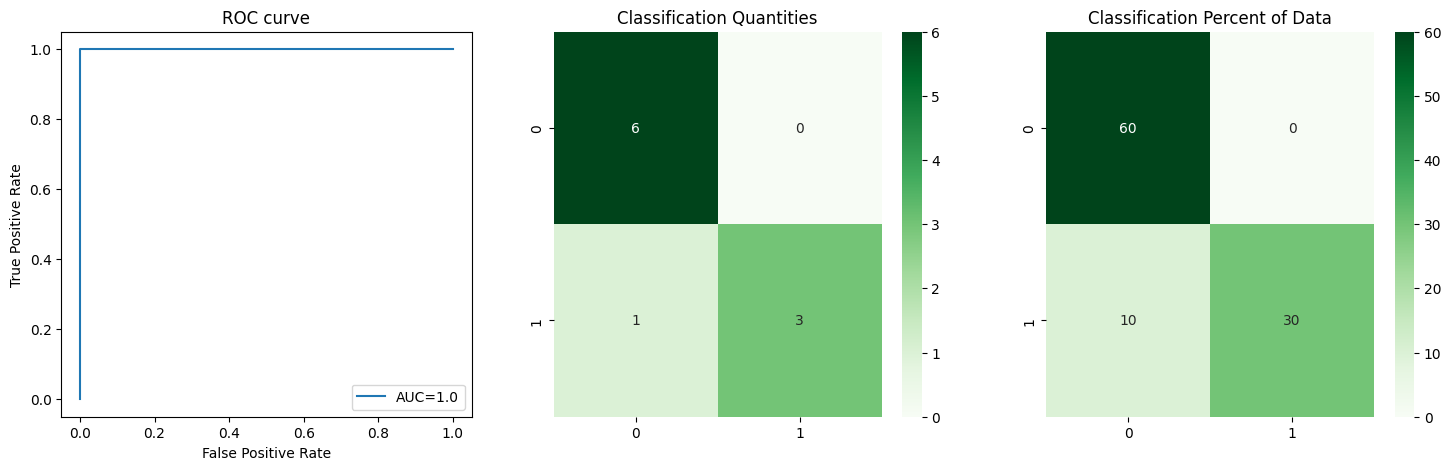

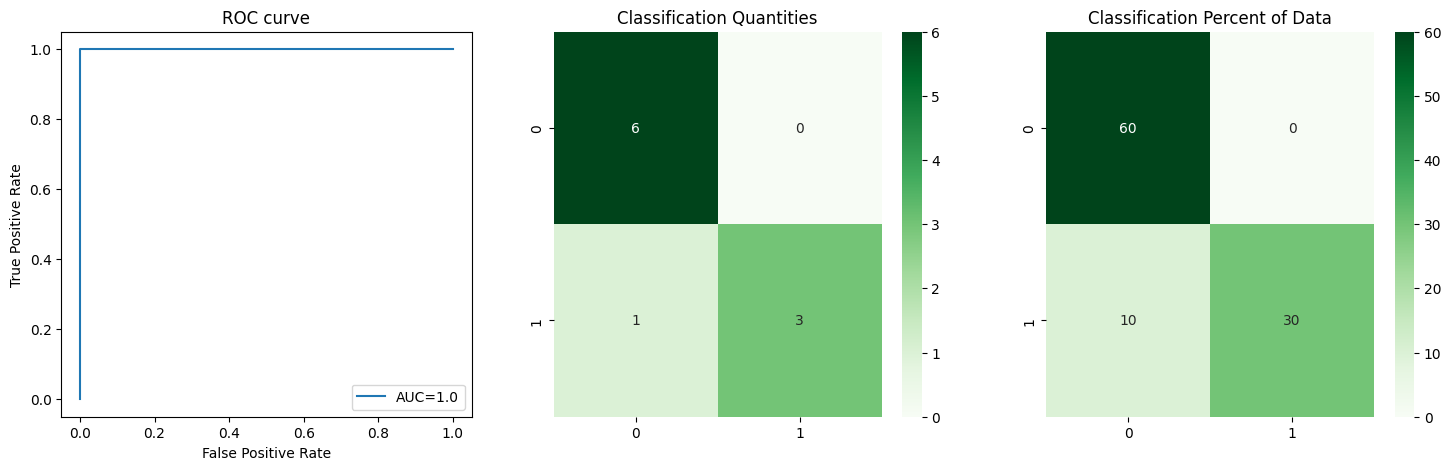

In [81]:
# Results for fourth dataset
print('Order of results:', model_names)
# Calculate AUC
for i, tbl in enumerate(res_table_4.keys()):
    auc_i = pd.DataFrame({'model': [model_names[i]], 'auc': [model_auc(res_table_4[tbl])]})
    model_aucs = pd.concat([model_aucs, auc_i])

# Results for first dataset
for i, tbl in enumerate(res_table_4.keys()):
    classification_plots(res_table_4[tbl])

### Numeric results (average AUC, average runtime) by model

In [90]:
# Average inference time across datasets
model_aucs.groupby(['model'], as_index=False).agg(average = ('auc', 'mean')).round(4)
# Average AUC across datasets
model_runtimes.groupby(['model'], as_index=False).agg(average = ('run_time', 'mean')).round(4)

,model,average
0,m1,0.8214
1,m2,0.9305


,model,average
0,m1,5.1875
1,m2,4.6050
